In [1]:
import pandas as pd
import numpy as np
import requests
import json
from sklearn.preprocessing import StandardScaler

metros = pd.read_csv('../csv/METRO_DEMOGRAPHICS_CLEAN.csv')

metros['store'] = 0
metros.tail()

,metro,enroll_hs_up,enroll_hs_up_p,enroll_college_up,enroll_college_up_p,pop_25_up,education_grad_prof_up,education_grad_prof_up_p,education_hs_up,education_hs_up_p,...,population_18_up_female,population_18_up_female_p,occ_male_management_bus_fin_p,occ_male_computer_eng_sci_p,occ_male_edu_legal_comserv_p,occ_female_management_bus_fin_p,occ_female_computer_eng_sci_p,occ_female_edu_legal_comserv_p,pop_25_up_p,store
492,"York-Hanover, PA Metro Area",25762,25.0,21430,20.8,320624,33943,10.6,294784,91.9,...,181596,50.7,53.6,78.0,30.6,46.4,22.0,69.4,69.90,0
493,"Youngstown-Warren-Boardman, OH-PA Metro Area",26062,23.5,23494,21.2,384636,33853,8.8,353422,91.9,...,220529,51.3,55.2,81.9,34.0,44.8,18.1,66.0,71.48,0
494,"Yuba City, CA Metro Area",9814,20.6,10697,22.5,118465,7382,6.2,94115,79.4,...,67192,49.8,50.2,48.4,34.8,49.8,51.6,65.2,64.92,0
495,"Yuma, AZ Metro Area",13501,27.8,8390,17.3,133866,8669,6.5,103317,77.2,...,74477,48.0,53.9,73.2,33.5,46.1,26.8,66.5,64.67,0
496,"Zanesville, OH Micro Area",3284,18.1,3599,19.8,59029,2824,4.8,53793,91.1,...,34402,51.3,51.9,71.5,36.4,48.1,28.5,63.6,68.31,0


In [2]:
# Get list of store locations
# Use API to get county
# https://geocoding.geo.census.gov/geocoder/geographies/onelineaddress?address=4600+Silver+Hill+Rd%2C+Washington%2C+DC+20233&benchmark=2020&format=json&vintage=Census2020_Census2020
# Use county to search for metro area
# Create feature list using metro area

micro_locs_df = pd.read_csv('../csv/micro_locations_clean.csv')

dstr = '850 3rd Ave Brooklyn, NY 11232'
micro_locs_df.replace(dstr, '851 3rd Ave Brooklyn, NY 11232', inplace=True)

estr = '655 Merrick Ave Westbury, NY 11590'
micro_locs_df.replace(estr, '737 Merrick Ave Westbury, NY 11590', inplace=True)

fstr = '3710 Highway 100 South St. Louis Park, MN 55416'
micro_locs_df.replace(fstr, '5911 Oxford St 55416', inplace=True)


micro_locs = micro_locs_df['store_address_full'].to_numpy()
print(micro_locs[:5])


['1100 E Edinger Ave Tustin, CA 92780' '3089 Nutley St Fairfax, VA 22031'
 '11755 Mosteller Rd Sharonville, OH 45241'
 '13929 N Central Expy Dallas, TX 75243'
 '1349 Som Center Rd Mayfield Heights, OH 44124']


In [3]:
counties = []
for micro_loc in micro_locs:
  add = str(micro_loc).replace(' ', '+')
  url = f'https://geocoding.geo.census.gov/geocoder/geographies/onelineaddress?address={add}&benchmark=2020&format=json&vintage=Census2020_Census2020'
  
  response = requests.get(url)
  res = json.loads(response.text)
  if not res['result']['addressMatches']:
    print('address not matched', add)
    break
  county = res['result']['addressMatches'][0]['geographies']['Counties'][0]['NAME']
  counties += [county]

print(counties[:5])

['Orange County', 'Fairfax County', 'Hamilton County', 'Dallas County', 'Cuyahoga County']


In [4]:
counties_df = pd.read_csv('../csv/CENSUS_COUNTY_INFO.csv');
counties_df.head(10)

,CBSA Code,Metropolitan Division Code,CSA Code,CBSA Title,Metropolitan/Micropolitan Statistical Area,Metropolitan Division Title,CSA Title,County/County Equivalent,State Name,FIPS State Code,FIPS County Code,Central/Outlying County
0,10100.0,NaN,NaN,"Aberdeen, SD",Micropolitan Statistical Area,NaN,NaN,Brown County,South Dakota,46.0,13.0,Central
1,10100.0,NaN,NaN,"Aberdeen, SD",Micropolitan Statistical Area,NaN,NaN,Edmunds County,South Dakota,46.0,45.0,Outlying
2,10140.0,NaN,NaN,"Aberdeen, WA",Micropolitan Statistical Area,NaN,NaN,Grays Harbor County,Washington,53.0,27.0,Central
3,10180.0,NaN,NaN,"Abilene, TX",Metropolitan Statistical Area,NaN,NaN,Callahan County,Texas,48.0,59.0,Outlying
4,10180.0,NaN,NaN,"Abilene, TX",Metropolitan Statistical Area,NaN,NaN,Jones County,Texas,48.0,253.0,Outlying
5,10180.0,NaN,NaN,"Abilene, TX",Metropolitan Statistical Area,NaN,NaN,Taylor County,Texas,48.0,441.0,Central
6,10220.0,NaN,NaN,"Ada, OK",Micropolitan Statistical Area,NaN,NaN,Pontotoc County,Oklahoma,40.0,123.0,Central
7,10300.0,NaN,220.0,"Adrian, MI",Micropolitan Statistical Area,NaN,"Detroit-Warren-Ann Arbor, MI",Lenawee County,Michigan,26.0,91.0,Central
8,10380.0,NaN,NaN,"Aguadilla-Isabela, PR",Metropolitan Statistical Area,NaN,NaN,Aguada Municipio,Puerto Rico,72.0,3.0,Central
9,10380.0,NaN,NaN,"Aguadilla-Isabela, PR",Metropolitan Statistical Area,NaN,NaN,Aguadilla Municipio,Puerto Rico,72.0,5.0,Central


In [5]:
metros_with_stores = []
for county in counties:
  c = counties_df[counties_df['County/County Equivalent'] == county]['CBSA Title'].values[0]
  if counties_df[counties_df['County/County Equivalent'] == county]['Metropolitan/Micropolitan Statistical Area'].values[0] == 'Micropolitan Statistical Area':
    c += ' Micro Area'
  if counties_df[counties_df['County/County Equivalent'] == county]['Metropolitan/Micropolitan Statistical Area'].values[0] == 'Metropolitan Statistical Area':
    c += ' Metro Area'

  metros_with_stores += [c]

print(metros_with_stores)


['Beaumont-Port Arthur, TX Metro Area', 'Washington-Arlington-Alexandria, DC-VA-MD-WV Metro Area', 'Chattanooga, TN-GA Metro Area', 'Dallas-Fort Worth-Arlington, TX Metro Area', 'Cleveland-Elyria, OH Metro Area', 'Columbus, OH Metro Area', 'Burlington-South Burlington, VT Metro Area', 'Columbus, GA-AL Metro Area', 'Hanford-Corcoran, CA Metro Area', 'New York-Newark-Jersey City, NY-NJ-PA Metro Area', 'Duluth, MN-WI Metro Area', 'Jacksonville, FL Metro Area', 'New York-Newark-Jersey City, NY-NJ-PA Metro Area', 'Minneapolis-St. Paul-Bloomington, MN-WI Metro Area', 'Detroit-Warren-Dearborn, MI Metro Area', 'Baltimore-Columbia-Towson, MD Metro Area', 'Amsterdam, NY Micro Area', 'Boston-Cambridge-Newton, MA-NH Metro Area', 'Chicago-Naperville-Elgin, IL-IN-WI Metro Area', 'Carbondale-Marion, IL Metro Area', 'Chicago-Naperville-Elgin, IL-IN-WI Metro Area', 'Atlanta-Sandy Springs-Alpharetta, GA Metro Area', 'Atlanta-Sandy Springs-Alpharetta, GA Metro Area', 'Denver-Aurora-Lakewood, CO Metro Are

In [11]:
#metros_names = metros[['metro']]

for v_m in metros_with_stores:
  newval = metros_with_stores.count(v_m)
  metros['store'] = metros['store'].mask((metros['metro'] == v_m), newval**2 )


In [12]:
metros_data_df = metros.copy()
metros_data_df

,metro,enroll_hs_up,enroll_hs_up_p,enroll_college_up,enroll_college_up_p,pop_25_up,education_grad_prof_up,education_grad_prof_up_p,education_hs_up,education_hs_up_p,...,population_18_up_female,population_18_up_female_p,occ_male_management_bus_fin_p,occ_male_computer_eng_sci_p,occ_male_edu_legal_comserv_p,occ_female_management_bus_fin_p,occ_female_computer_eng_sci_p,occ_female_edu_legal_comserv_p,pop_25_up_p,store
0,"Aberdeen, WA Micro Area",3261,23.3,1206,8.6,56049,3654,6.5,51048,91.1,...,29479,48.0,45.4,69.5,28.8,54.6,30.5,71.2,72.94,0
1,"Abilene, TX Metro Area",9390,19.7,13710,28.8,113152,11847,10.5,98971,87.5,...,66243,48.8,53.7,92.8,30.4,46.3,7.2,69.6,63.35,0
2,"Adrian, MI Micro Area",4792,22.2,5013,23.2,69784,5559,8.0,64527,92.5,...,39089,49.8,52.1,74.6,36.7,47.9,25.4,63.3,70.52,0
3,"Akron, OH Metro Area",32696,20.6,46975,29.6,489895,62814,12.8,450503,92.0,...,288816,51.8,53.6,74.4,36.0,46.4,25.6,64.0,69.98,0
4,"Albany, GA Metro Area",8496,22.4,10725,28.3,96691,8962,9.3,81663,84.5,...,60251,53.6,47.0,82.4,26.8,53.0,17.6,73.2,65.79,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
492,"York-Hanover, PA Metro Area",25762,25.0,21430,20.8,320624,33943,10.6,294784,91.9,...,181596,50.7,53.6,78.0,30.6,46.4,22.0,69.4,69.90,0
493,"Youngstown-Warren-Boardman, OH-PA Metro Area",26062,23.5,23494,21.2,384636,33853,8.8,353422,91.9,...,220529,51.3,55.2,81.9,34.0,44.8,18.1,66.0,71.48,0
494,"Yuba City, CA Metro Area",9814,20.6,10697,22.5,118465,7382,6.2,94115,79.4,...,67192,49.8,50.2,48.4,34.8,49.8,51.6,65.2,64.92,0
495,"Yuma, AZ Metro Area",13501,27.8,8390,17.3,133866,8669,6.5,103317,77.2,...,74477,48.0,53.9,73.2,33.5,46.1,26.8,66.5,64.67,0


In [13]:
# metros_features_df = metros.loc[metros['store'] > 0]
# metros_target_df = metros.loc[metros['store'] == 0]

# metros_features_df
# targets = metros_features_df['store'].values
# print(targets)

metros_data_targets = metros_data_df['store'].values
print(metros_data_targets)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 1 0 4 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 9 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [14]:
training_values = metros_data_df.iloc[:, 1:]
# value_columns = ["enroll_college_up_p","pop_25_up_p","education_grad_prof_up_p","education_hs_up_p","education_bachelors_up_p","households_with_computer_p","households_with_broadband_p","income_less_10000_p","income_10000_14999_p","income_15000_24999_p","income_25000_34999_p","income_35000_49999_p","income_50000_74999_p","income_75000_99999_p","income_100000_149999_p","income_150000_199999_p","income_more_200000_p","population","population_male_p","population_15_19_p","population_20_24_p","population_25_34_p","population_35_44_p","population_45_54","population_45_54_p","population_55_59_p","population_60_64_p","population_65_74","population_65_74_p","population_75_84_p","population_85_up_p","population_18_up_male_p","population_18_up_female_p","occ_male_management_bus_fin_p","occ_male_computer_eng_sci_p","occ_male_edu_legal_comserv_p","occ_female_management_bus_fin_p","occ_female_computer_eng_sci_p","occ_female_edu_legal_comserv_p"]
# value_columns = ['population', "pop_25_up_p", 'enroll_college_up_p', 'education_bachelors_up_p', 'households_with_computer_p', 'households_with_broadband_p', "income_50000_74999_p","income_75000_99999_p","income_100000_149999_p","income_150000_199999_p","income_more_200000_p"]
value_columns = ['population', 'enroll_college_up','households_with_broadband', "income_50000_74999","income_75000_99999","income_100000_149999", 'education_bachelors_up', 'education_hs_up', 'population_18_up_male', 'household_median_income', 'household_mean_income', "population_median_age"]


training_values = training_values[value_columns]

In [15]:
# Scale values
X = StandardScaler().fit_transform(training_values)

In [16]:
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_vars, kmo_model = calculate_kmo(X)
print(kmo_vars, kmo_model)

[0.90848207 0.93413612 0.88014648 0.85849042 0.91821948 0.92659428
 0.88317617 0.9267505  0.85526981 0.66804789 0.69747539 0.16073721] 0.8800867836443851


/Users/michael/opt/anaconda3/envs/py310/lib/python3.10/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


In [17]:
feat_cols = ['feature'+str(i) for i in range(X.shape[1])]
normal_values = pd.DataFrame(X, columns=feat_cols)
normal_values.head(3)

,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11
0,-0.352023,-0.380679,-0.357822,-0.394796,-0.386578,-0.360951,-0.327875,-0.350012,-0.348580,-0.655440,-0.689321,1.120000
1,-0.283213,-0.256319,-0.294253,-0.266574,-0.318378,-0.319175,-0.285590,-0.297007,-0.281383,-0.701166,-0.847426,-1.169843
2,-0.337070,-0.342816,-0.341807,-0.373043,-0.350964,-0.333458,-0.311018,-0.335103,-0.335446,-0.145365,-0.486786,0.495497


In [43]:
from sklearn.decomposition import PCA
pca_values = PCA(n_components=2)
pc_metros = pca_values.fit(X)
pc_metros_transformed = pca_values.fit_transform(X)
# pc_metros.explained_variance_ratio_
pc_metros_transformed_df = pd.DataFrame(data=pc_metros_transformed, columns=['PC1', 'PC2'])
pc_metros_transformed_df.head(10)

,PC1,PC2
0,-1.292012,-0.700895
1,-1.048232,-0.883212
2,-1.106104,-0.218855
3,0.272558,0.043861
4,-1.230275,-1.274458
5,-0.979157,0.051611
6,1.082547,1.128430
7,-1.285441,-0.970923
8,0.650050,-0.352539
9,-1.249565,-1.242407


In [50]:
evr = pc_metros.explained_variance_ratio_
print(f'Explained variaton for each Principal Component {evr}')
print(f'Total explained variation: {round(100 * np.sum(evr), 2)}%')

Explained variaton for each Principal Component [0.77264683 0.13468266]
Total explained variation: 90.73%


In [39]:
loadings = pc_metros.components_
number_pc = pc_metros.n_features_
pc_list = ['PC'+str(i) for i in list(range(1, number_pc + 1))]

loadings_dict = dict(zip(pc_list, loadings))
loadings_df = pd.DataFrame.from_dict(loadings_dict)

loadings_df['var'] = training_values.columns.values

loadings_df = loadings_df.set_index('var')

loadings_df

,PC1,PC2
var,,
population,0.326445,-0.080130
enroll_college_up,0.324090,-0.063953
households_with_broadband,0.326846,-0.072892
income_50000_74999,0.323106,-0.091918
income_75000_99999,0.325679,-0.075399
income_100000_149999,0.326931,-0.054209
education_bachelors_up,0.324826,-0.046447
education_hs_up,0.326772,-0.071847
population_18_up_male,0.326595,-0.075862


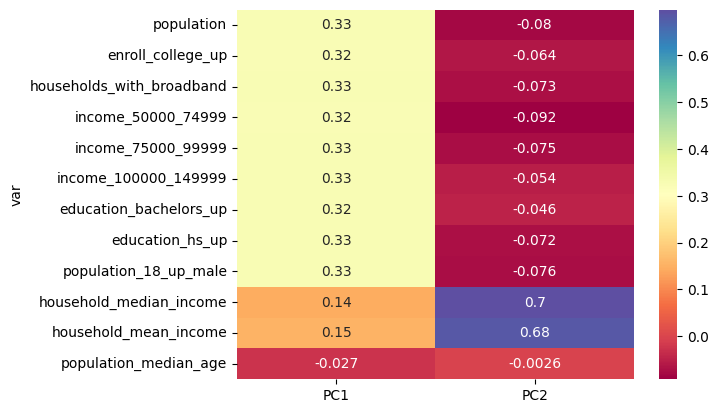

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.heatmap(loadings_df, annot=True, cmap='Spectral')
plt.show()


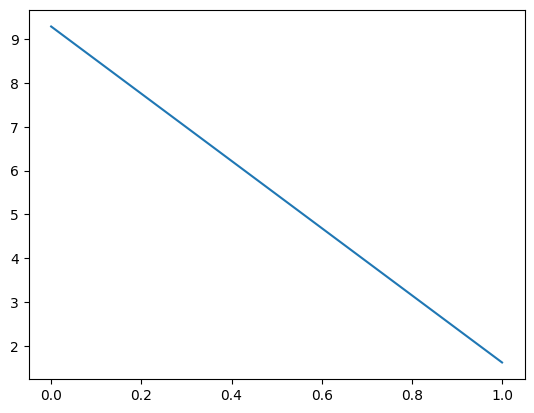

In [41]:
pc_metros.explained_variance_

plt.plot(pc_metros.explained_variance_)
#plt.plot(np.cumsum(pc_metros.explained_variance_ratio_))
plt.show()

In [33]:
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier()
classifier.fit(pc_metros_transformed, metros_data_targets)

DecisionTreeClassifier()

In [34]:
metros_targets = metros_target_df[value_columns]

metros_targets_transformed = pca_values.fit_transform(metros_targets)

In [35]:
predictions = classifier.predict(metros_targets_transformed)
print(len(predictions))

477


In [36]:
metros_target_df_out = metros_target_df
metros_target_df_out['p'] = predictions

metros_target_df_out

/var/folders/r1/3sdccdsj38d8wtp_d3wb4m9m0000gn/T/ipykernel_24955/2569082310.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metros_target_df_out['p'] = predictions


,metro,enroll_hs_up,enroll_hs_up_p,enroll_college_up,enroll_college_up_p,pop_25_up,education_grad_prof_up,education_grad_prof_up_p,education_hs_up,education_hs_up_p,...,population_18_up_female_p,occ_male_management_bus_fin_p,occ_male_computer_eng_sci_p,occ_male_edu_legal_comserv_p,occ_female_management_bus_fin_p,occ_female_computer_eng_sci_p,occ_female_edu_legal_comserv_p,pop_25_up_p,store,p
0,"Aberdeen, WA Micro Area",3261,23.3,1206,8.6,56049,3654,6.5,51048,91.1,...,48.0,45.4,69.5,28.8,54.6,30.5,71.2,72.94,0,0
1,"Abilene, TX Metro Area",9390,19.7,13710,28.8,113152,11847,10.5,98971,87.5,...,48.8,53.7,92.8,30.4,46.3,7.2,69.6,63.35,0,0
2,"Adrian, MI Micro Area",4792,22.2,5013,23.2,69784,5559,8.0,64527,92.5,...,49.8,52.1,74.6,36.7,47.9,25.4,63.3,70.52,0,0
3,"Akron, OH Metro Area",32696,20.6,46975,29.6,489895,62814,12.8,450503,92.0,...,51.8,53.6,74.4,36.0,46.4,25.6,64.0,69.98,0,9
4,"Albany, GA Metro Area",8496,22.4,10725,28.3,96691,8962,9.3,81663,84.5,...,53.6,47.0,82.4,26.8,53.0,17.6,73.2,65.79,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
492,"York-Hanover, PA Metro Area",25762,25.0,21430,20.8,320624,33943,10.6,294784,91.9,...,50.7,53.6,78.0,30.6,46.4,22.0,69.4,69.90,0,0
493,"Youngstown-Warren-Boardman, OH-PA Metro Area",26062,23.5,23494,21.2,384636,33853,8.8,353422,91.9,...,51.3,55.2,81.9,34.0,44.8,18.1,66.0,71.48,0,0
494,"Yuba City, CA Metro Area",9814,20.6,10697,22.5,118465,7382,6.2,94115,79.4,...,49.8,50.2,48.4,34.8,49.8,51.6,65.2,64.92,0,0
495,"Yuma, AZ Metro Area",13501,27.8,8390,17.3,133866,8669,6.5,103317,77.2,...,48.0,53.9,73.2,33.5,46.1,26.8,66.5,64.67,0,0
